# Setup

- Download Spark 2.2, unpack to /opt/spark (or anywhere)
- Set SPARK_HOME var to /opt/spark (or where it was unpacked to)
- Download BigDL 0.7, unpack anywhere
- Set BIGDL_HOME var to unpacked BigDL directory
- do `pip install bigdl==0.7` somewhere
- download https://gist.github.com/lukovnikov/461d1165ea04317d2be6b66995ffa73c
- start jupyter using the script (must be marked as executable)


## Important:
for this script to work, the MNIST files from http://yann.lecun.com/exdb/mnist/ must be downloaded in mnist/ directory (or somewhere else, and the "p" kwarg in load_mnist() must be changed then)

In [1]:
import pyspark
from pyspark import SparkContext
import numpy as np
import re
import struct
import gzip
import matplotlib as mpl
from matplotlib import pyplot as plt
import time

from bigdl.util.common import *

In [2]:
plt.rcParams['figure.figsize'] = [16, 8]

In [3]:
init_engine()

In [4]:
pyspark.__version__

'2.2.3'

In [5]:
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.util.common import Sample
from bigdl.dataset.transformer import *

# MNIST classification with logistic regression

## Loading data

In [6]:
def load_mnist(p="mnist/"):
    def read_idx(filename):      # loads mnist into numpy array
        with gzip.open(filename) as f:
            zero, data_type, dims = struct.unpack('>HBB', f.read(4))
            shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
            return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    train_data = read_idx(p+"train-images-idx3-ubyte.gz")
    train_labels = read_idx(p+"train-labels-idx1-ubyte.gz")
    test_data = read_idx(p+"t10k-images-idx3-ubyte.gz")
    test_labels = read_idx(p+"t10k-labels-idx1-ubyte.gz")
    
    train_mean, train_std = np.mean(train_data), np.std(train_data)
    #train_data = train_data[:200]
    #train_labels = train_labels[:200]
    train_imgs, train_lbls = sc.parallelize(train_data), sc.parallelize(train_labels)
    test_imgs, test_lbls = sc.parallelize(test_data), sc.parallelize(test_labels)
    train_rdd = train_imgs.zip(train_lbls).map(lambda x: 
                                               Sample.from_ndarray((x[0] - train_mean)/train_std, x[1]+1))
    test_rdd= test_imgs.zip(test_lbls).map(lambda x: 
                                               Sample.from_ndarray((x[0] - train_mean)/train_std, x[1]+1))
    return train_rdd, test_rdd

mnist_train_rdd, mnist_test_rdd = load_mnist()
print(mnist_train_rdd.count())

/home/denis/conda/envs/spark/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


60000


### Show data sample

[5.0, 0.0, 4.0, 1.0, 9.0, 2.0, 1.0, 3.0]


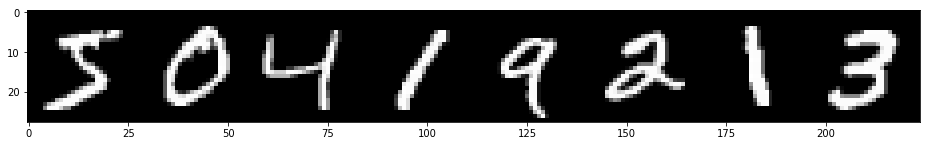

In [7]:
selection = mnist_train_rdd.take(8)
plt.imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) 
                            for s in selection]),cmap='gray')
#plt.axis('off')
print([float(s.label.to_ndarray()) - 1 for s in selection])

## Hyperparams

In [8]:
# Parameters
learning_rate = 0.5
training_epochs = 10
batch_size = 2048

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

## Model

TODO:
- define the LeNet-5 model: https://engmrk.com/lenet-5-a-classic-cnn-architecture/
    - (tip: don't forget to add a reshape layer for input)

In [9]:
model = Sequential()
model.add(Reshape([1, 28, 28]))
model.add(SpatialConvolution(1, 6, 5, 5))
model.add(Tanh())
model.add(SpatialMaxPooling(2, 2, 2, 2))
model.add(Tanh())
model.add(SpatialConvolution(6, 12, 5, 5))
model.add(SpatialMaxPooling(2, 2, 2, 2))
model.add(Reshape([12 * 4 * 4]))
model.add(Linear(12 * 4 * 4, 100))
model.add(Tanh())
model.add(Linear(100, 10))
model.add(LogSoftMax())

creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createTanh
creating: createSpatialMaxPooling
creating: createTanh
creating: createSpatialConvolution
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createTanh
creating: createLinear
creating: createLogSoftMax


## Optimizer

TODO:
- define optimizer with the model, training data and other settings defined above (Hyperparams)

In [10]:
mnist_optimizer = Optimizer(
    model=model,
    training_rdd=mnist_train_rdd,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=learning_rate),
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer


In [11]:
mnist_optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=mnist_test_rdd,
    trigger=EveryEpoch(),
    val_method=[Loss(ClassNLLCriterion()), Top1Accuracy()]
)

creating: createEveryEpoch
creating: createClassNLLCriterion
creating: createLoss
creating: createTop1Accuracy


In [12]:
appname = "mnist_cnn_{}".format(time.time())
train_summary = TrainSummary(log_dir="./trainlogs/", app_name=appname)
valid_summary = ValidationSummary(log_dir="./trainlogs/", app_name=appname)
mnist_optimizer.set_train_summary(train_summary)
mnist_optimizer.set_val_summary(valid_summary)

creating: createTrainSummary
creating: createValidationSummary


TODO:
- train the model

In [13]:
trained_mnist_model = mnist_optimizer.optimize()

## Evaluate trained model on test data

TODO:
- compute classification accuracy as well as the loss over both test and train datasets
    - (tip: check "metrics" in "API Guide")

In [14]:
result = model.evaluate(mnist_test_rdd, batch_size, [Loss(ClassNLLCriterion()), Top1Accuracy()])
result_train = model.evaluate(mnist_train_rdd, batch_size, [Loss(ClassNLLCriterion()), Top1Accuracy()])

creating: createClassNLLCriterion
creating: createLoss
creating: createTop1Accuracy
creating: createClassNLLCriterion
creating: createLoss
creating: createTop1Accuracy


In [16]:
print(result[0], result[1])
print(result_train[0], result_train[1])

Evaluated result: 0.07243697345256805, total_num: 20, method: Loss Evaluated result: 0.9790999889373779, total_num: 10000, method: Top1Accuracy
Evaluated result: 0.0741349458694458, total_num: 118, method: Loss Evaluated result: 0.9789333343505859, total_num: 60000, method: Top1Accuracy


## Visualize training

TODO:
- plot the validation loss together with the validation accuracy and training loss
    - (tip: read_scalar)

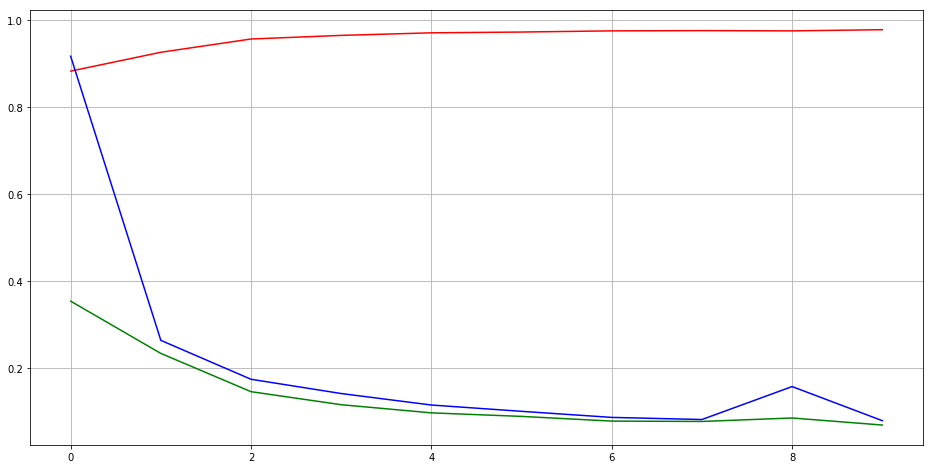

In [17]:
validloss = np.array(valid_summary.read_scalar("Loss"))
validacc = np.array(valid_summary.read_scalar("Top1Accuracy"))
trainloss = np.array(train_summary.read_scalar("Loss"))
trainloss = trainloss[:, 1]
validsize = validloss.shape[0]
trainloss = trainloss.reshape((validsize, -1))
trainloss = trainloss.mean(1)
#print(trainloss)
plt.plot(validloss[:,1], "g")
plt.plot(validacc[:,1], "r")
plt.plot(trainloss, "b")
plt.grid(True)

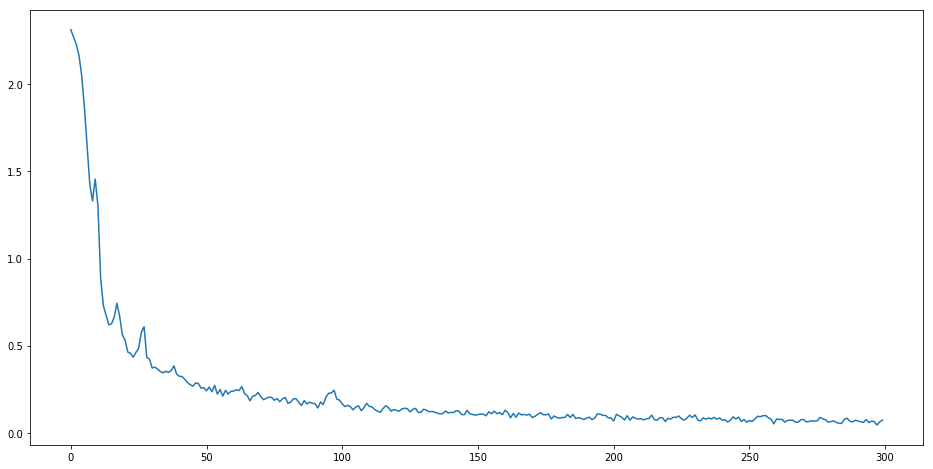

In [18]:
plt.plot(np.array(train_summary.read_scalar("Loss"))[:, 1])